##Auto Encoders
Autoencoders are the architecture of Neural Network which is combination of Encoder and Decoder. Encoder reduced the dimention of data to linear (in ideal scenario, it may vary case to case) and Decoder will regenerate the data from rncoded value.
Thare are various use cases for the Auto Encoders, Denoising of images/signal is one of them that we are going to address today.

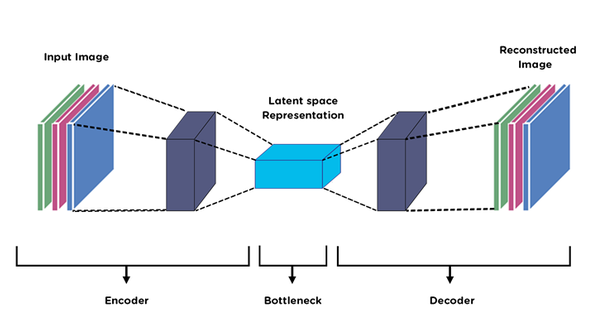

####Import Necessary Libraries

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from tensorflow.keras.models import Model

#### Add Gausian Noise to Original Images to prepare noisy data

In [8]:
# Function to add Gaussian noise to images
def add_gaussian_noise(images, mean=0, stddev=0.1):
    noisy_images = []
    for image in images:
        noise = np.random.normal(mean, stddev, image.shape)
        noisy_image = np.clip(image + noise, 0, 1) # Clip values to stay within [0, 1] range
        noisy_images.append(noisy_image)
    return np.array(noisy_images)

In [9]:
# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add Gaussian noise to training and testing images
train_noisy_images = add_gaussian_noise(train_images)
test_noisy_images = add_gaussian_noise(test_images)

#### A simple dataset check, to view how or noisy images look like vs original

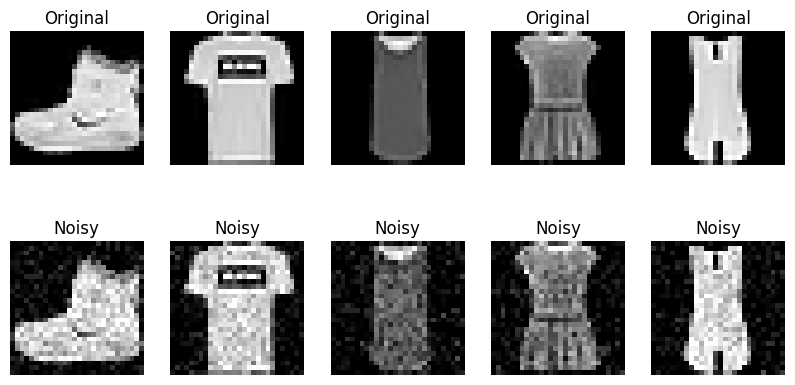

In [10]:

# Example: Plot original and noisy images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(train_noisy_images[i], cmap='gray')
    plt.title('Noisy')
    plt.axis('off')
plt.show()

####Architecture of Autoencoder

In [11]:
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    return autoencoder

In [12]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928 

#### Prepare data by adding one more channel dimension and Train the model on Epochs 30 and Batch Size=256

In [13]:
# Prepare data
train_images_noisy = train_noisy_images[..., np.newaxis]  # Add channel dimension
train_images_clean = train_images[..., np.newaxis]  # Add channel dimension

# Build and compile the autoencoder
input_shape = train_images_noisy.shape[1:]
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
history = autoencoder.fit(train_images_noisy, train_images_clean,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

Epoch 1/30
188/188 [==============================] - 5s 15ms/step - loss: 0.3208 - val_loss: 0.2824
Epoch 2/30
188/188 [==============================] - 2s 12ms/step - loss: 0.2774 - val_loss: 0.2757
Epoch 3/30
188/188 [==============================] - 2s 13ms/step - loss: 0.2726 - val_loss: 0.2719
Epoch 4/30
188/188 [==============================] - 2s 12ms/step - loss: 0.2697 - val_loss: 0.2694
Epoch 5/30
188/188 [==============================] - 2s 12ms/step - loss: 0.2672 - val_loss: 0.2672
Epoch 6/30
188/188 [==============================] - 3s 14ms/step - loss: 0.2650 - val_loss: 0.2654
Epoch 7/30
188/188 [==============================] - 2s 12ms/step - loss: 0.2633 - val_loss: 0.2641
Epoch 8/30
188/188 [==============================] - 2s 13ms/step - loss: 0.2620 - val_loss: 0.2631
Epoch 9/30
188/188 [==============================] - 2s 12ms/step - loss: 0.2610 - val_loss: 0.2617
Epoch 10/30
188/188 [==============================] - 2s 13ms/step - loss: 0.2602 - val_lo

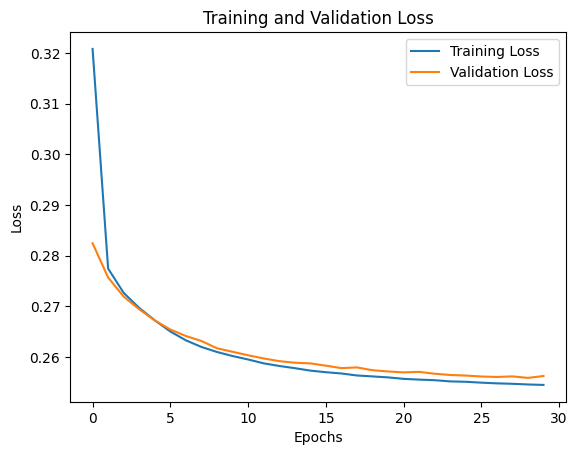

In [14]:
# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step - loss: 0.2572
Test Loss: 0.25717461109161377
313/313 [==============================] - 1s 2ms/step


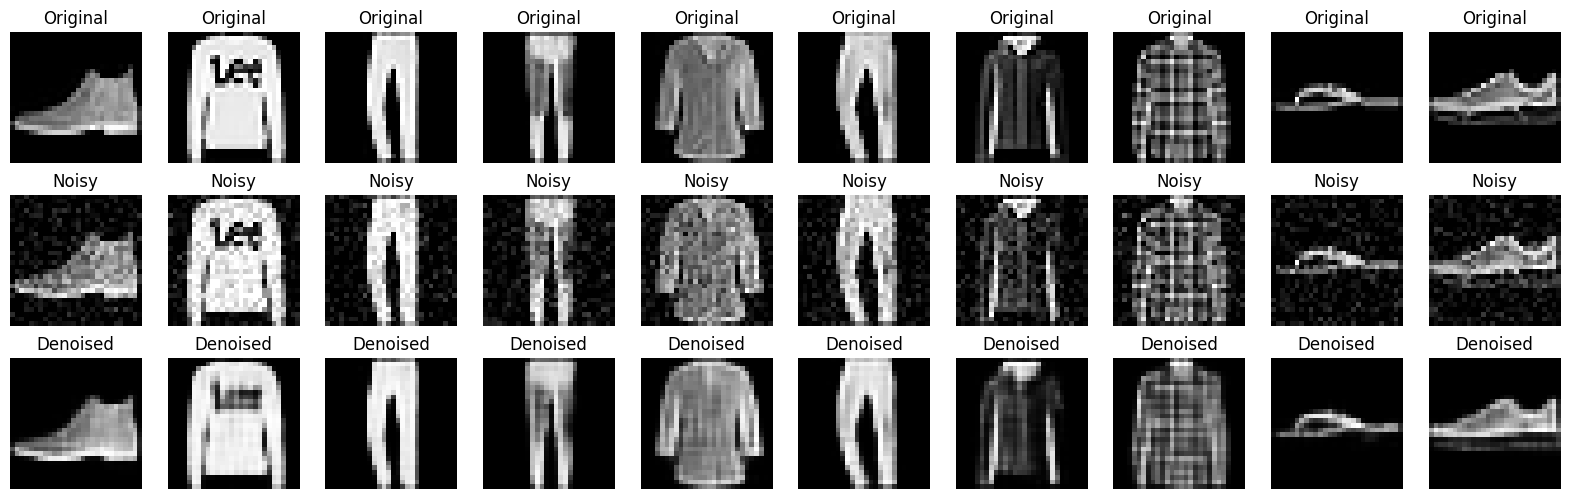

In [15]:
# Prepare test data
test_images_noisy = test_noisy_images[..., np.newaxis]  # Add channel dimension
test_images_clean = test_images[..., np.newaxis]  # Add channel dimension

# Evaluate the autoencoder on test data
test_loss = autoencoder.evaluate(test_images_noisy, test_images_clean)

print("Test Loss:", test_loss)

# Denoise test images
denoised_images = autoencoder.predict(test_images_noisy)

# Plot original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    plt.subplot(3, n, i + 1)
    plt.imshow(test_images_clean[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Noisy
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_images_noisy[i].squeeze(), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # Denoised
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].squeeze(), cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

plt.show()